In [1]:
from factor_estimator import FactorEstimator, get_common_index_codes, get_prices
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Factor investing is one of the most interesting approaches to "outperform the market" if the market is a usual market cap weighted portfolio (like MSCI World, MSCI ACWI, FTSE All World or to a degree a S&P500).
When diving into the literature one finds a whole host of factors which may be valuable. The most intersting ones come from Fama and French (Size (SmB), Value (HmL), Conservative (CvA) and Robustness (RmW). There are more out there like Momentum (Carhart, 1997) or Liquidity (Pástor, Stambaugh 2003).
Since the author of this analysis is based out of Germany, the amount of different investment options is limited. Thus we keep with the following selection, where the number represents the MSCI Index code:

In [2]:
index_codes = get_common_index_codes()
index_codes.pop("Small-Cap")
print(index_codes)


{'MSCI World': '990100', 'Value': '705130', 'Quality': '702787', 'Multi-Factor': '706536', 'Momentum': '703755', 'High Dividend': '136064', 'Low Volatility (World)': '129896', 'Small-Cap (Value)': '139249'}


The question asked in this analysis is: **How do I mix the ETFs for the indecies** above?

In general there are two approaches for factor investing. The integrated approach uses one etf where the stocks are picked to satisfy more then one factor at a time. Those ETFs are a one-stop solution, but have significantly higher costs. Also there is currently only a very limited selection available in Germany. The most important one is [iShares Edge MSCI World Multifactor](https://www.justetf.com/de-en/etf-profile.html?isin=IE00BZ0PKT83) which is based on the WORLD DIVERSIFIED MULTI-FACTOR index.
The TER for this is 0.5% and thus its ~0.35% higher than a market neutral MSCI World and ~0.2% higher than most 'single factor ETF' (exception is Value Weighted Small Caps).

The other approach is a *index of indicies* where you mix different ETFs to target more than a single factor. The reasoning behind that is, that factors are not stable over time and it is desireable to target more than one for continuity.

In this analysis we will try to estimate the 5 factors of the Fama French 5-Factor model. Those are MKT, SMB, HML, CWA and RMW. We then try to find the most suitable combination of ETFs for our purposes.

Let's get the data first. The data is directly taking from MSCI, and is thus available for a longer range. We examine data from 1997-2020, since this is the time span with daily data available. Every point is always normalized to the 01/01/1997, so we can look at it like we invested a euro back then.

In [3]:
data = []
start_date="19970101"
for key in index_codes.keys():
    code = index_codes[key]
    d = get_prices(code,start_date=start_date)
    d.rename(columns={"level_eod":key}, inplace=True)
    d.set_index("date")
    data.append(d)
df = pd.concat(data).groupby(level=0).first()
df.set_index("date")

,MSCI World,Value,Quality,Multi-Factor,Momentum,High Dividend,Low Volatility (World),Small-Cap (Value)
date,,,,,,,,
1997-01-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1997-01-02,0.992293,1.012044,0.991558,0.995729,0.988328,0.989355,0.996012,0.992434
1997-01-03,0.998856,1.020642,1.004794,0.998923,1.000483,0.995411,0.997666,1.000117
1997-01-06,1.001294,1.018963,1.005847,0.991557,1.003350,0.996223,1.000183,1.001541
1997-01-07,1.002676,1.019877,1.012472,1.001161,1.008144,0.997789,1.000277,1.006273
...,...,...,...,...,...,...,...,...
2020-12-28,3.262952,NaN,6.193829,NaN,8.190560,2.358850,3.470467,8.328861
2020-12-29,3.269514,NaN,6.212763,NaN,8.193189,2.371316,3.481083,8.225125
2020-12-30,3.274234,NaN,6.215572,NaN,8.208674,2.375127,3.482950,8.318555


To check the data and to understand, let's chart the data:

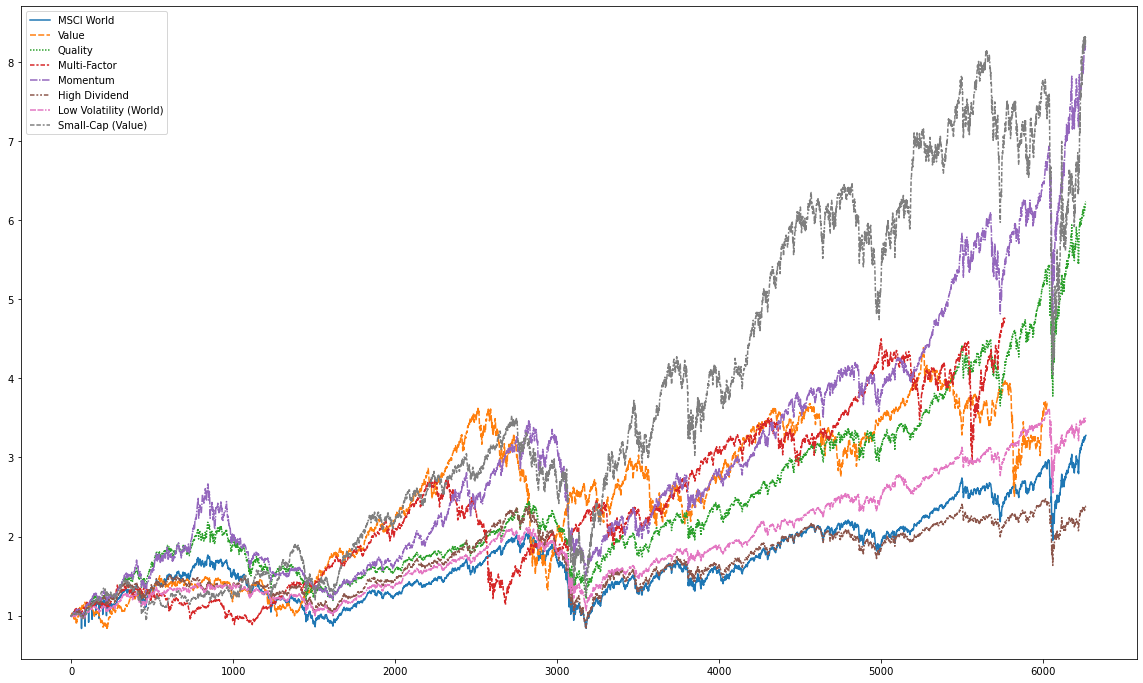

In [4]:
plt.figure(figsize=(20, 12))
gfg = sns.lineplot(data = df)

We can see that all factors except for High Dividend outperform the MSCI World (and I am not sure if the high dividend is accumulating the dividends, likely not).
We can also see that the two best running factors are Momentum and Small-Cap (Value).

Lets now calculate the factors for each of our indicies. The idea is, that the change of market price w.r.t to the risk free return can be descriped as 
\begin{equation}
    r_f = a \cdot MKT+b \cdot SMB \cdot HML+d \cdot RMW+e \cdot CMA
\end{equation}
The original Fama French paper knew a,b,c,d and e for a given portfolio (those are metrics like P/E), and deterimed the influence factors.
We do it the other way around. We know the influence factors from the paper and want to determine the 'sizeness' of an index (so we determine a,b,c,d,e).

In [5]:
factor_estimator = FactorEstimator()
factors = {}
fit_results = {}
for key in index_codes.keys():
    code = index_codes[key]
    print("calculating for ",code)
    fitted_factors, results, data = factor_estimator.estimate(code,start_date=start_date)
    factors[key] = fitted_factors
    fit_results[key] = results

calculating for  990100
calculating for  705130
calculating for  702787
calculating for  706536
calculating for  703755
calculating for  136064
calculating for  129896
calculating for  139249


Before we move forward, lets have a look at the quality of the fit:

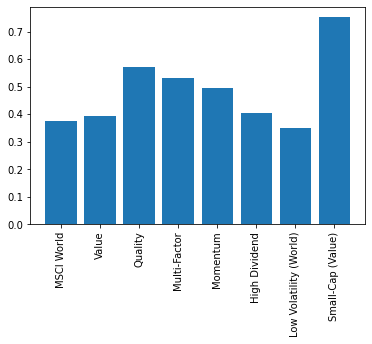

In [6]:
D={}
for key in factors.keys():
    D[key] = fit_results[key].rsquared
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()


From my perspective the r-squared value is relativily low. Only Small cap (Value) reaches > 0.7. The values of 0.35 are rather weak and maybe we should run further analysis here?
The original paper also quotes relativly low r² values. Maybe that's just normal?

We can also have a quick look at the global factorness of each index. Factorness is defined as
\begin{equation}
\phi = \sum_i f_i
\end{equation}
where $f_i$ is the individual factor. The key question of this analysis is if $\phi$ is the factor to optimize on or how to weight the individual contributions.

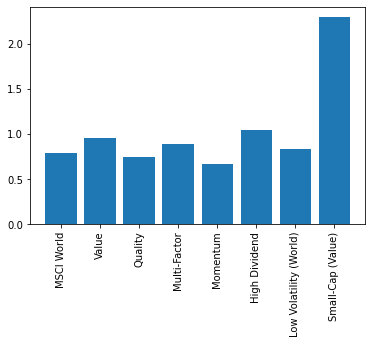

In [7]:
D={}
for key in factors.keys():
    D[key] = factors[key].sum()
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()

What we can see here is kind of telling. The Multi-Factor index is not outstanding! If the Mult-Factor index is clearly surperior we would have expected a high value here.
Let's look into the details and the individual factor for each of the 5 factors of the model:

<ipython-input-8-b9eb012f6ba2>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


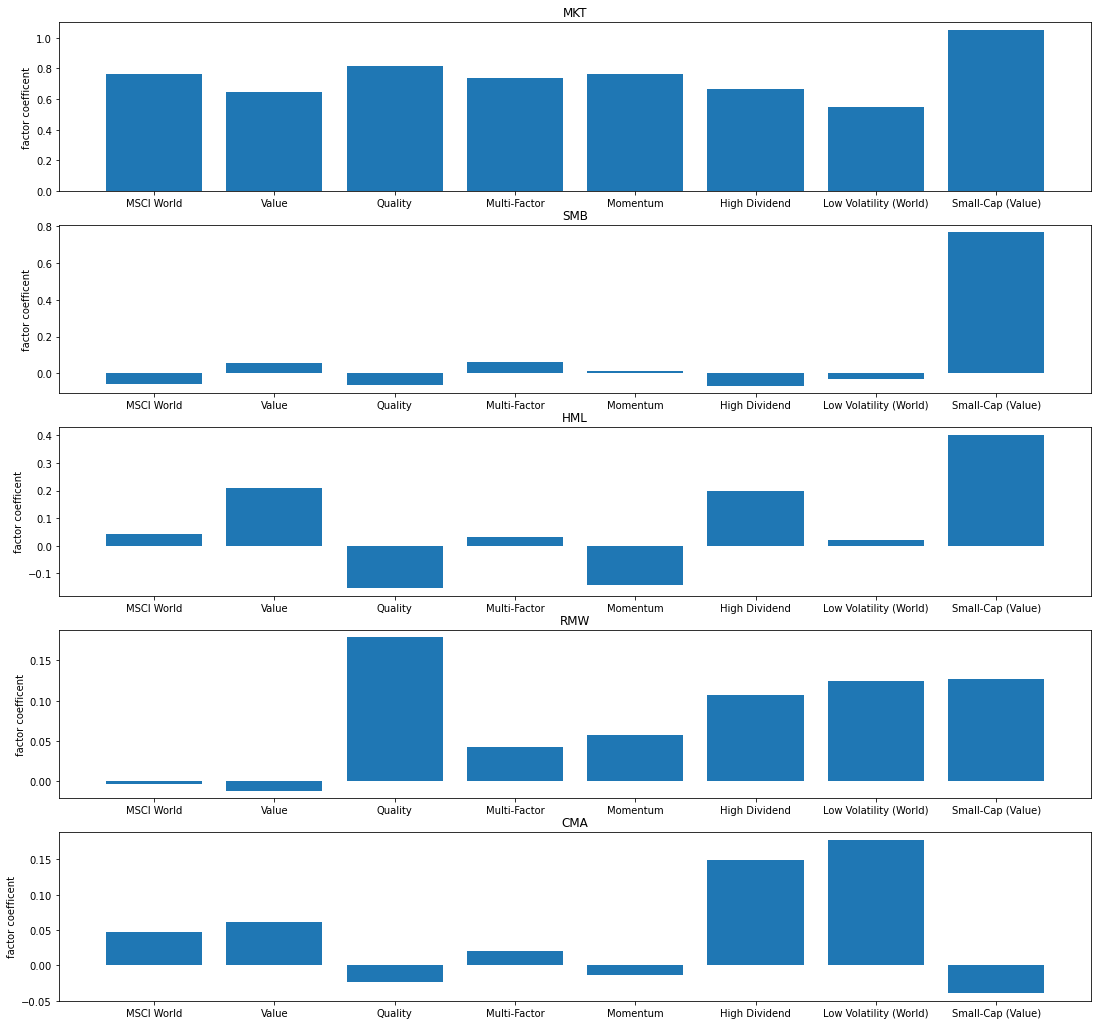

In [8]:
fig, axs = plt.subplots(5)
i = 0

for factorname in ["MKT","SMB","HML","RMW","CMA"]:
    D = {}
    for key in factors.keys():
        D[key] = factors[key][factorname]
    axs[i].bar(*zip(*D.items()))
    axs[i].set_title(factorname)
    #axs[i].set_ylim(-0.2,0.5)
    axs[i].set_ylabel("factor coefficent")
    i+=1
    


fig.set_size_inches(18.5, 18)
fig.show()

And for completness, lets look at it the other way around and see it grouped by the index:

<ipython-input-9-b7a9d13182b1>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-9-b7a9d13182b1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


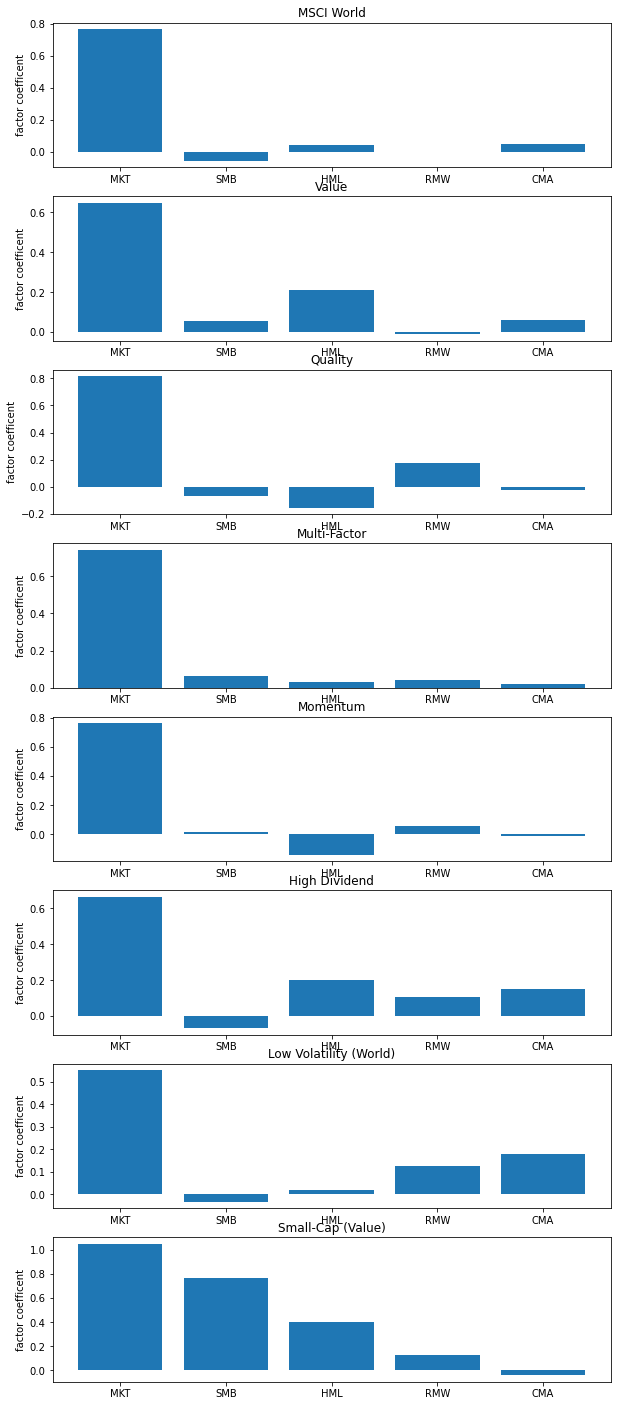

In [9]:
fig, ax = plt.subplots(len(index_codes))

width = 0.35  # the width of the bars
i = 0
for key in factors.keys():
    D = {}
    for factorname in ["MKT","SMB","HML","RMW","CMA"]:
        D[factorname] = factors[key][factorname]
        
    ax[i].bar(*zip(*D.items()),label=key)
    ax[i].set_title(key)
    #ax[i].set_ylim(-0.2,0.5)
    ax[i].set_ylabel("factor coefficent")
    i+=1
    


fig.tight_layout()
fig.set_size_inches(10, 25)
fig.show()

What can we learn from here? First: Small Cap (Value) seams to be a beast! It offers exposure to the market, SMB and HML! And it does not even have negative contributions to RMW and CMA. Wow! One needs to remind oneselve, that Small Cap (Value) only has a [single ETF](https://www.justetf.com/de-en/etf-profile.html?groupField=index&from=search&isin=IE00BSPLC413) in Germany which is relativly expensive (0.3% TER)

Lets move into the optimization. We first define our factor matrix

In [10]:
factor_matrix = pd.DataFrame.from_dict(factors).drop(["Intercept"],axis=0)

The factorness vector $\vec{f}$ can now be expressed as:
\begin{equation}
\vec{f} = \underline{F} \cdot \alpha
\end{equation}
Where $\underline{F}$ is the factor matrix and $\alpha$ our asset allocation vector.



In [11]:
numberOfIndecies = len(index_codes)
def factorness(alpha):
  return factor_matrix.dot(alpha)


For the reference, lets calculate the factorness vector and the total factorness for a pure multi-factor portfolio:

In [12]:
alpha_multi_factor = [0.0,0.0,0.0,1,0.0,0,0,0.0]
pure_multi = factorness(alpha_multi_factor)
for alloc, name in zip(alpha_multi_factor,factor_matrix.columns):
    print(name, alloc )
print(pure_multi)
print("Total Factorness: ", pure_multi.sum())

MSCI World 0.0
Value 0.0
Quality 0.0
Multi-Factor 1
Momentum 0.0
High Dividend 0
Low Volatility (World) 0
Small-Cap (Value) 0.0
MKT    0.739753
SMB    0.061760
HML    0.032210
RMW    0.042584
CMA    0.020865
dtype: float64
Total Factorness:  0.8971726309539969


We can now try to use a numerical optimization in order to find the result which maximizes the total factorness $\phi$. One key thing here is, that we need to specifiy bonds. If not the optimizer will throw everything into Small Cap (Value), since it's a beast.
Lets define bounds as \[0, 0.334\] and lets also deactivate the use of multi factor:

In [13]:

from scipy.optimize import minimize
# objective function
def func(alpha):
    return -1*factorness(alpha).sum()

# constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# initial weights
w0 =  np.ones((len(index_codes),1))/len(index_codes)

# define bounds
b    = (0.0, 0.334) 
bnds = [b for i in range(0,numberOfIndecies)]
bnds[3] = (0.0,0.0001)
# minimize
sol  = minimize(func,
                w0,
                bounds      = bnds,
                constraints = cons)
print(sol.fun)
for alloc, name in zip(sol.x,factor_matrix.columns):
    print(name,"\n\t", alloc )
print(factorness(sol.x))

-1.440483093537711
MSCI World 
	 4.591789622711124e-15
Value 
	 0.33199999999999696
Quality 
	 5.782280542925864e-15
Multi-Factor 
	 7.9007167561734315e-16
Momentum 
	 6.033837525456518e-15
High Dividend 
	 0.3339999999999939
Low Volatility (World) 
	 2.9282132274488504e-15
Small-Cap (Value) 
	 0.33399999999998903
MKT    0.787370
SMB    0.251116
HML    0.270592
RMW    0.074438
CMA    0.056968
dtype: float64


The result is a portfolio which uses 33% Value, 33% Small-Cap Value and 33% High Dividend. For me it is intersting to see, that High Dividend adds something to the portfolio. But also it is clear that High Dividend stocks are also value stocks.

**This factorness outpeforms the multi-factor etf by far and in every dimension! Also the multi-factor ETF is way more expensive. So why take it?**

For the reference, lets look at a few other portfolios. From the returns chart we may say, that we would like to use Small Cap (Value) and Momentum since they are well running. We may add either some Quality or Value to it to increase diversivication:

In [14]:
small_momentum_value_alpha = [0.0,0.,0.2,0,0.4,0,0,0.4]
factors_small_momentum_value = factorness(small_momentum_value_alpha)
for alloc, name in zip(small_momentum_value_alpha,factor_matrix.columns):
    print(name, alloc )
print(factors_small_momentum_value)
print(factors_small_momentum_value.sum())

MSCI World 0.0
Value 0.0
Quality 0.2
Multi-Factor 0
Momentum 0.4
High Dividend 0
Low Volatility (World) 0
Small-Cap (Value) 0.4
MKT    0.887256
SMB    0.298797
HML    0.073538
RMW    0.109362
CMA   -0.025912
dtype: float64
1.3430406081266637


In [15]:
small_momentum_quality_alpha = [0.0,0.2,0,0,0.4,0,0,0.4]
factors_small_quality_value = factorness(small_momentum_quality_alpha)
for alloc, name in zip(small_momentum_quality_alpha,factor_matrix.columns):
    print(name, alloc )
print(factors_small_quality_value)
print(factors_small_quality_value.sum())

MSCI World 0.0
Value 0.2
Quality 0
Multi-Factor 0
Momentum 0.4
High Dividend 0
Low Volatility (World) 0
Small-Cap (Value) 0.4
MKT    0.853919
SMB    0.322540
HML    0.146213
RMW    0.071318
CMA   -0.009041
dtype: float64
1.3849485091878817


Those two options are very interesting! They are slighly worse than the optimized porfolio, but not much (0.08 and 0.1 respecitivly). But they offer a higher MKT value! MKT is the exposure to the market and should be the strongest factor in the mix. It may thus be desireable to take one of those.

**This boils down to the key open question: How to weight the different factors?** 
